# import libraries

In [1]:
import scipy
import numpy
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from math import nan
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.impute import KNNImputer



# đọc - chia dữ liệu

In [2]:
filepath = '../car-dataset.csv'

def load_dataframe (filepath):
  return pd.read_csv(filepath)


def shuffle_rows (dataframe):
  return dataframe.sample(frac=1, random_state = 2).reset_index(drop=True)

def get_car_data(ratio = (0.8, 0.1, 0.1)): # filetype: .csv | list_type: pandas dataframe | ratio: (train - val - test)
  # tập train lớn nên chọn 8 1 1
  data = load_dataframe(filepath)
  data = shuffle_rows(data)

  data_x = data.drop(columns=['Price'])
  data_y = data['Price']

  train_size = int(len(data) * ratio[0])
  val_size = int(len(data) * ratio[1])
  test_size = int(len(data) * ratio[2])

  x_train = data_x[:train_size]
  y_train = data_y[:train_size]

  x_val = data_x[train_size:train_size+val_size]
  y_val = data_y[train_size:train_size+val_size]

  x_test = data_x[train_size+val_size:]
  y_test = data_y[train_size+val_size:]


  return x_train, y_train, x_val, y_val, x_test, y_test

df = load_dataframe(filepath)

df = shuffle_rows(df)

x_train, y_train, x_val, y_val, x_test, y_test = get_car_data()

# khai báo pipeline tiền xử lí

In [3]:
class DataPreprocessor:
    def __init__ (self):
        # num features truoc khi prep for step 2
        self.numeric_features = ['adv-year', 'adv-month', 'reg-year', 'runned-miles', 'engine-size', 'engine-power', 'annual-tax', 'wheelbase', 'length', 'width', 'height', 'average-mpg', 'top-speed', 'seat-num', 'door-num']
        self.drop_feats = ['genmodel', 'genmodel-id', 'adv-id', 'adv-year', 'adv-month', 'reg-year', 'annual-tax', 'wheelbase', 'height', 'door-num']
        self.feats_with_most_nan = []
        self.NaN_ratio_threshold = 0.5 # >= x thi loai bo
        self.schema = pd.DataFrame([
            ['age', 'Float64', 'none', 'mean'],
            ['runned-miles', 'Float64', 'none', 'mean'],
            ['engine-size', 'Float64', 'none', 'mean'],
            ['engine-power', 'Float64', 'none', 'median'],
            ['width', 'Float64', 'none', 'median'],
            ['length', 'Float64', 'none', 'median'],
            ['average-mpg', 'Float64', 'none', 'median'],
            ['top-speed', 'Float64', 'none', 'median'],
            ['seat-num', 'Float64', 'one-hot', 'mode'],
            ['maker', 'Float64', 'target', 'mean'], # encode first
            ['color', 'Float64', 'target', 'mode'],
            ['bodytype', 'Float64', 'one-hot', 'mode'],
            ['gearbox', 'Float64', 'one-hot', 'mode'],
            ['fuel-type', 'Float64', 'one-hot', 'mode'],
        ])

        self.continuous_cols = ['age', 'runned-miles', 'engine-size', 'engine-power', 'width', 'length', 'average-mpg', 'top-speed']

    def change_column_names (self, dataframe): #step 1
        dataframe = dataframe.copy()
        dataframe.columns = [col.lower().replace('_', '-') for col in dataframe.columns]
        return dataframe
    
    def perform_light_cleaning (self, dataframe): # step 2: loại bỏ đơn vị và chuyển đổi kiểu dữ liệu
        dataframe = dataframe.copy()
        for col in self.numeric_features:
            if col in dataframe.columns:
                dataframe[col] = dataframe[col].astype(str).str.extract(r'(\d+(?:\.\d+)?)')[0]
                dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
        return dataframe
    
    def add_feature_age (self, dataframe): # step 3: thêm tuổi xe
        dataframe = dataframe.copy()
        if 'adv-year' in dataframe.columns and 'reg-year' in dataframe.columns:
            dataframe['age'] = dataframe['adv-year'] - dataframe['reg-year']
        return dataframe
    
    def drop_features (self, dataframe): # step 4: loại bỏ các cột không cần thiết
        dataframe = dataframe.copy()
        return dataframe.drop(columns=self.drop_feats, errors='ignore')
    
    def drop_rows_with_nan_price (self, X, y): # step 5: loại bỏ các hàng có giá trị NaN trong cột 'price'
        X = X.copy()
        y = y.copy()
        mask = y.notna()
        X = X[mask]
        y = y[mask]
        return X, y
    
    def drop_rows_with_nan (self, dataframe, y): # step 6: drop mẫu nếu NaN ở cột có nhiều nan nhất
        dataframe = dataframe.copy()
        for col in self.feats_with_most_nan:
            if col in dataframe.columns:
                dataframe = dataframe[dataframe[col].notna()]
                y = y[dataframe.index]
        return dataframe, y
    
    def drop_rows_with_nan_ratio (self, X, y): # step 6.5: loai bo cac hang co NaN vuot qua nguong cho phep
        X = X.copy()
        y = y.copy()
        nan_ratio = X.isna().sum(axis=1) / X.shape[1]
        mask = nan_ratio < self.NaN_ratio_threshold
        X = X[mask]
        y = y[mask]
        return X, y

    def fit_for_schema (self, x_train, y_train): # step 7: fit cho schema
        # fit cho dac trung lien tuc
        self.continuous_stats = {}
        for feature in self.schema.values:
            if feature[2] == 'none' and feature[0] in x_train.columns:
                feature_name = feature[0]
                col = x_train[feature_name]
                self.continuous_stats[feature_name] = {
                    'mode': col.value_counts().index[:3].tolist(),
                    'mean': col.mean(),
                    'median': col.median()
                }

        # fit tren label
        self.target_stats = {
            'mean': y_train.mean(),
            'median': y_train.median(),
        }

        # fit cho dac trung phan loai, target encoding, one-hot encoding
        self.categorical_stats = {}
        self.target_encoders = {}
        self.one_hot_encoders = {}
        for feature in self.schema.values:
            if feature[2] != 'none' and feature[0] in x_train.columns:
                feature_name = feature[0]
                col = x_train[feature_name]
                self.categorical_stats[feature_name] = {
                    'mode': col.value_counts().index[:3].tolist(),
                }
            
            if feature[2] == 'target':
                encoder = TargetEncoder(cols=[feature_name], handle_unknown='value', smoothing=0.1)
                encoder.fit(x_train[feature_name], y_train)
                self.target_encoders[feature_name] = encoder

            elif feature[2] == 'one-hot':
                encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
                encoder.fit(x_train[[feature_name]])
                self.one_hot_encoders[feature_name] = encoder

        # KNN IMPUTER
        # knn_imputer = KNNImputer(n_neighbors=5)
        # self.imputer = knn_imputer.fit(x_train[self.continuous_cols])

    def add_nan_flags(self, dataframe): # step 7.5: thêm cột đánh dấu NaN
        dataframe = dataframe.copy()
        for feature in self.schema.values:
            feature_name = feature[0]
            if feature_name in dataframe.columns:
                dataframe[f'{feature_name}_is_nan'] = dataframe[feature_name].isna().astype(int)

        return dataframe

    def impute (self, dataframe): # step 8: thay thế giá trị NaN
        dataframe = dataframe.copy()
        for feature in self.schema.values:
            feature_name = feature[0]
            feature_type = feature[1]
            feature_encode_method = feature[2]
            feature_impute_method = feature[3]
            
            # dataframe[self.continuous_cols] = self.imputer.transform(dataframe[self.continuous_cols])

            if feature_name in dataframe.columns and feature_name in self.continuous_stats:
                dataframe[feature_name] = dataframe[feature_name].astype(feature_type)

                if feature_impute_method == 'mean':
                    dataframe[feature_name] = dataframe[feature_name].fillna(self.continuous_stats[feature_name]['mean'])
                elif feature_impute_method == 'median':
                    dataframe[feature_name] = dataframe[feature_name].fillna(self.continuous_stats[feature_name]['median'])
                elif feature_impute_method == 'mode':
                    modes = self.continuous_stats[feature_name]['mode']
                    dataframe[feature_name] = dataframe[feature_name].fillna(modes[0] if pd.notna(modes[0]) else modes[1])

            elif feature_name in dataframe.columns and feature_name in self.categorical_stats:
                if feature_impute_method == 'mode':
                    modes = self.categorical_stats[feature_name]['mode']
                    dataframe[feature_name] = dataframe[feature_name].fillna(modes[0] if pd.notna(modes[0]) else modes[1])
                elif feature_encode_method == 'target' and feature_impute_method == 'mean':
                    dataframe[feature_name] = dataframe[feature_name].fillna(self.target_stats['mean'])

        return dataframe
                
    def encode (self, dataframe): # step 9: encode
        dataframe = dataframe.copy()

        for feature in self.schema.values:
            feature_name = feature[0]
            feature_type = feature[1]
            feature_encode_method = feature[2]

            if feature_name in dataframe.columns:
                if feature_encode_method == 'target':
                    if feature_name in self.target_encoders:
                        encoder = self.target_encoders[feature_name]
                        dataframe[feature_name] = encoder.transform(dataframe[feature_name])[feature_name]
                
                elif feature_encode_method == 'one-hot':
                    if feature_name in self.one_hot_encoders:
                        encoder = self.one_hot_encoders[feature_name]
                        encoded_data = encoder.transform(dataframe[[feature_name]])
                        new_col_names = encoder.get_feature_names_out([feature_name])
                        new_col_names = [col.replace(' ', '_').lower() for col in new_col_names]  # Replace spaces with underscores

                        encoded_df_part = pd.DataFrame(encoded_data, columns=new_col_names, index= dataframe.index)
                        df_tmp = dataframe.drop(columns=[feature_name])
                        dataframe = pd.concat([df_tmp, encoded_df_part], axis=1)

        return dataframe

    def fit_for_scaler (self, x_train): # step 10: fit cho scaler
        self.scaler = RobustScaler()
        self.scaler.fit(x_train)

    def scale (self, dataframe): # step 11: scale
        dataframe = dataframe.copy()
        if hasattr(self, 'scaler'):
            return pd.DataFrame(self.scaler.transform(dataframe), columns=dataframe.columns, index=dataframe.index)
        else:
            raise ValueError("co gi do sai sai")

    def fit_transform_pipeline (self, x_train, y_train):
        x_train = self.change_column_names(x_train)
        x_train = self.perform_light_cleaning(x_train)
        x_train = self.add_feature_age(x_train)
        x_train = self.drop_features(x_train)
        x_train, y_train = self.drop_rows_with_nan_price(x_train, y_train)
        x_train, y_train = self.drop_rows_with_nan(x_train, y_train)
        x_train, y_train = self.drop_rows_with_nan_ratio(x_train, y_train)

        self.fit_for_schema(x_train, y_train)

        x_train = self.add_nan_flags(x_train)
        x_train = self.impute(x_train)
        x_train = self.encode(x_train)

        self.fit_for_scaler(x_train)

        x_train = self.scale(x_train)

        return x_train, y_train

    def transform_pipeline (self, X, y, drop_nan = True):
        X = self.change_column_names(X)
        X = self.perform_light_cleaning(X)
        X = self.add_feature_age(X)
        X = self.drop_features(X)

        X, y = self.drop_rows_with_nan_price(X, y)
        
        if drop_nan == True: 
            # X, y = self.drop_rows_with_nan(X, y)
            X, y = self.drop_rows_with_nan_ratio(X, y)

        X = self.add_nan_flags(X)
        X = self.impute(X)
        X = self.encode(X)

        X = self.scale(X)
        

        return X, y
    

In [4]:
Prep = DataPreprocessor()

In [5]:
x_train[['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Engine_size', 'Engine_power', 'Annual_Tax', 'Wheelbase', 'Length', 'Width', 'Height', 'Average_mpg', 'Top_speed', 'Seat_num', 'Door_num']]

,Adv_year,Adv_month,Reg_year,Runned_Miles,Engine_size,Engine_power,Annual_Tax,Wheelbase,Length,Width,Height,Average_mpg,Top_speed,Seat_num,Door_num
0,2021,5,2019.0,4987,3.0L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,2018,8,2015.0,35345,1.3L,94.0,0,2510.0,4021.0,1944.0,1481.0,83.1 mpg,113 mph,5.0,5.0
2,2018,8,2005.0,64000,3.5L,276.0,NaN,2650.0,4310.0,1815.0,1320.0,24.8 mpg,155 mph,2.0,2.0
3,2018,8,2007.0,104155,2.0L,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,2018,5,2012.0,71000,1.6L,113.0,30,2850.0,4380.0,2067.0,1626.0,61.4 mpg,114 mph,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,2018,5,2016.0,37750,2.4L,220.0,195,2815.0,4838.0,2119.0,1604.0,48.7 mpg,130 mph,5.0,5.0
214600,2018,5,2009.0,78000,1.6L,90.0,30,2608.0,4260.0,1773.0,1458.0,64.2 mpg,112 mph,5.0,5.0
214601,2021,5,2019.0,17000,2.0L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0
214602,2021,5,2019.0,22284,1.0L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0


# tổng quan

In [6]:
numeric_cols = ['adv-year', 'adv-month', 'reg-year', 'runned-miles', 'engine-size', 'engine-power', 'annual-tax', 'wheelbase', 'length', 'width', 'height', 'average-mpg', 'top-speed', 'seat-num', 'door-num']


In [7]:
x_train = Prep.change_column_names(x_train)
x_train = Prep.perform_light_cleaning(x_train)

In [8]:
print("===== DATATYPES SAU LIGHT CLEANING =====")
x_train.dtypes

===== DATATYPES SAU LIGHT CLEANING =====


maker            object
genmodel         object
genmodel-id      object
adv-id           object
adv-year          int64
adv-month         int64
color            object
reg-year        float64
bodytype         object
runned-miles    float64
engine-size     float64
gearbox          object
fuel-type        object
engine-power    float64
annual-tax      float64
wheelbase       float64
height          float64
width           float64
length          float64
average-mpg     float64
top-speed       float64
seat-num        float64
door-num        float64
dtype: object

In [9]:
print("===== KIỂM TRA 10 DÒNG ĐẦU =====")
x_train[numeric_cols]

===== KIỂM TRA 10 DÒNG ĐẦU =====


,adv-year,adv-month,reg-year,runned-miles,engine-size,engine-power,annual-tax,wheelbase,length,width,height,average-mpg,top-speed,seat-num,door-num
0,2021,5,2019.0,4987.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,2018,8,2015.0,35345.0,1.3,94.0,0.0,2510.0,4021.0,1944.0,1481.0,83.1,113.0,5.0,5.0
2,2018,8,2005.0,64000.0,3.5,276.0,NaN,2650.0,4310.0,1815.0,1320.0,24.8,155.0,2.0,2.0
3,2018,8,2007.0,104155.0,2.0,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,2018,5,2012.0,71000.0,1.6,113.0,30.0,2850.0,4380.0,2067.0,1626.0,61.4,114.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,2018,5,2016.0,37750.0,2.4,220.0,195.0,2815.0,4838.0,2119.0,1604.0,48.7,130.0,5.0,5.0
214600,2018,5,2009.0,78000.0,1.6,90.0,30.0,2608.0,4260.0,1773.0,1458.0,64.2,112.0,5.0,5.0
214601,2021,5,2019.0,17000.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0
214602,2021,5,2019.0,22284.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0


In [10]:
print("===== THỐNG KÊ TẬP TRAIN TRÊN CỘT LIÊN TỤC =====")
x_train.describe().round()

===== THỐNG KÊ TẬP TRAIN TRÊN CỘT LIÊN TỤC =====


,adv-year,adv-month,reg-year,runned-miles,engine-size,engine-power,annual-tax,wheelbase,height,width,length,average-mpg,top-speed,seat-num,door-num
count,214604.0,214604.0,214598.0,213764.0,212964.0,189122.0,176467.0,192149.0,192310.0,192085.0,192310.0,180965.0,179589.0,209358.0,210949.0
mean,2018.0,6.0,2013.0,48142.0,2.0,151.0,156.0,2564.0,1531.0,1896.0,4371.0,51.0,122.0,5.0,4.0
std,1.0,2.0,4.0,42393.0,10.0,85.0,121.0,491.0,164.0,151.0,424.0,16.0,19.0,1.0,1.0
min,2012.0,1.0,1960.0,0.0,0.0,17.0,0.0,0.0,0.0,1191.0,0.0,9.0,11.0,1.0,2.0
25%,2018.0,4.0,2010.0,14079.0,1.0,99.0,30.0,2511.0,1456.0,1780.0,4081.0,42.0,109.0,5.0,4.0
50%,2018.0,5.0,2014.0,39160.0,2.0,128.0,140.0,2640.0,1494.0,1884.0,4385.0,50.0,118.0,5.0,5.0
75%,2018.0,7.0,2016.0,75000.0,2.0,175.0,195.0,2752.0,1624.0,2020.0,4672.0,60.0,130.0,5.0,5.0
max,2021.0,33.0,2019.0,6363342.0,3500.0,740.0,555.0,5246.0,2660.0,2690.0,6165.0,471.0,226.0,17.0,7.0


In [11]:

y_train.describe().round()

count     213679.0
mean       14759.0
std        33110.0
min          100.0
25%         4990.0
50%         9298.0
75%        17249.0
max      9999999.0
Name: Price, dtype: float64

In [12]:
print("===== THỐNG KÊ CÁC CỘT PHÂN LOẠI =====")

cat_stats = []

for col in x_train.columns:
    if col not in numeric_cols:
        n_unique = x_train[col].nunique(dropna=True)
        n_notna = x_train[col].notna().sum()
        vc = x_train[col].value_counts(dropna=False, normalize=True).head(5)
        top_values = []
        for idx, val in vc.items():
            top_values.append(f"{idx}: {x_train[col].value_counts(dropna=False)[idx]} mẫu ({val:.2%})")
        cat_stats.append({
            "column": col,
            "n_unique": n_unique,
            "n_notna": n_notna,
            "top_1": top_values[0] if len(top_values) > 0 else "",
            "top_2": top_values[1] if len(top_values) > 1 else "",
            "top_3": top_values[2] if len(top_values) > 2 else "",
            "top_4": top_values[3] if len(top_values) > 3 else "",
            "top_5": top_values[4] if len(top_values) > 4 else "",
        })

cat_stats_df = pd.DataFrame(cat_stats)
display(cat_stats_df)

===== THỐNG KÊ CÁC CỘT PHÂN LOẠI =====


,column,n_unique,n_notna,top_1,top_2,top_3,top_4,top_5
0,maker,85,214604,Ford: 21504 mẫu (10.02%),Audi: 18018 mẫu (8.40%),Vauxhall: 16106 mẫu (7.50%),Volkswagen: 14487 mẫu (6.75%),BMW: 13756 mẫu (6.41%)
1,genmodel,865,214604,Corsa: 4464 mẫu (2.08%),Focus: 4129 mẫu (1.92%),Fiesta: 3800 mẫu (1.77%),X5: 2729 mẫu (1.27%),Juke: 2720 mẫu (1.27%)
2,genmodel-id,850,214604,94_9: 4464 mẫu (2.08%),29_14: 4129 mẫu (1.92%),29_13: 3800 mẫu (1.77%),8_39: 2729 mẫu (1.27%),64_14: 2720 mẫu (1.27%)
3,adv-id,214604,214604,55_7$$2: 1 mẫu (0.00%),59_25$$373: 1 mẫu (0.00%),94_9$$3352: 1 mẫu (0.00%),64_1$$57: 1 mẫu (0.00%),29_13$$1409: 1 mẫu (0.00%)
4,color,22,197091,Black: 38923 mẫu (18.14%),Silver: 32191 mẫu (15.00%),Blue: 30721 mẫu (14.32%),Grey: 29988 mẫu (13.97%),White: 27560 mẫu (12.84%)
5,bodytype,18,213833,Hatchback: 83042 mẫu (38.70%),SUV: 51564 mẫu (24.03%),Saloon: 18036 mẫu (8.40%),MPV: 17960 mẫu (8.37%),Coupe: 13604 mẫu (6.34%)
6,gearbox,3,214472,Manual: 136560 mẫu (63.63%),Automatic: 77804 mẫu (36.25%),nan: 132 mẫu (0.06%),Semi-Automatic: 108 mẫu (0.05%),
7,fuel-type,13,214281,Diesel: 106212 mẫu (49.49%),Petrol: 101942 mẫu (47.50%),Hybrid Petrol/Electric: 3586 mẫu (1.67%),Electric: 1048 mẫu (0.49%),Hybrid Petrol/Electric Plug-in: 813 mẫu (0.38%)


In [13]:
print("===== THỐNG KÊ DỮ LIỆU THIẾU =====")

def count_nan_zero_ratio(df):
    total_rows = len(df)

    nan_counts = df.isna().sum()
    nan_ratios = (nan_counts / total_rows).round(3)*100

    zero_counts = (df == 0).sum(numeric_only=True)
    zero_ratios = (zero_counts / total_rows).round(3)*100

    result = pd.DataFrame({
        'nan_count': nan_counts,
        'nan_ratio (%)': nan_ratios,
        'zero_count': zero_counts,
        'zero_ratio (%)': zero_ratios
    })

    return result.sort_values(by='nan_ratio (%)', ascending=False).reset_index(drop=False)

count_nan_zero_ratio(x_train)

===== THỐNG KÊ DỮ LIỆU THIẾU =====


,index,nan_count,nan_ratio (%),zero_count,zero_ratio (%)
0,annual-tax,38137,17.8,11272,5.3
1,top-speed,35015,16.3,0,0.0
2,average-mpg,33639,15.7,0,0.0
3,engine-power,25482,11.9,0,0.0
4,width,22519,10.5,0,0.0
5,wheelbase,22455,10.5,5958,2.8
6,height,22294,10.4,757,0.4
7,length,22294,10.4,68,0.0
8,color,17513,8.2,0,0.0
9,seat-num,5246,2.4,0,0.0


In [14]:
print("==== KIẺM TRA SƠ DỮ LIỆU BẤT THƯỜNG ====")
print("Số mẫu runned-miles < 0:", (x_train['runned-miles'] < 0).sum())
print("Số mẫu engine-size <= 0:", (x_train['engine-size'] <= 0).sum())
print("Số mẫu engine-power <= 0:", (x_train['engine-power'] <= 0).sum())
print("Số mẫu reg-year > adv-year:", (x_train['reg-year'] > x_train['adv-year']).sum())
print("Số mẫu wheelbase <= 0:", (x_train['wheelbase'] <= 0).sum())
print("Số mẫu width <= 0:", (x_train['width'] <= 0).sum())
print("Số mẫu length <= 0:", (x_train['length'] <= 0).sum())
print("Số mẫu height <= 0:", (x_train['height'] <= 0).sum())
print("Số mẫu month < 1 hay month > 12 <= 0:", (x_train['adv-month'] < 1).sum() + (x_train['adv-month'] > 12).sum())
print("Số mẫu top-speed <= 0:", (x_train['top-speed'] < 0).sum())
print("Số mẫu average-mpg <= 0:", (x_train['average-mpg'] < 0).sum())
print("Số mẫu seat-num <= 0:", (x_train['seat-num'] <= 0).sum())
print("Số mẫu door-num <= 0:", (x_train['door-num'] <= 0).sum())


==== KIẺM TRA SƠ DỮ LIỆU BẤT THƯỜNG ====
Số mẫu runned-miles < 0: 0
Số mẫu engine-size <= 0: 0
Số mẫu engine-power <= 0: 0
Số mẫu reg-year > adv-year: 110
Số mẫu wheelbase <= 0: 5958
Số mẫu width <= 0: 0
Số mẫu length <= 0: 68
Số mẫu height <= 0: 757
Số mẫu month < 1 hay month > 12 <= 0: 3
Số mẫu top-speed <= 0: 0
Số mẫu average-mpg <= 0: 0
Số mẫu seat-num <= 0: 0
Số mẫu door-num <= 0: 0


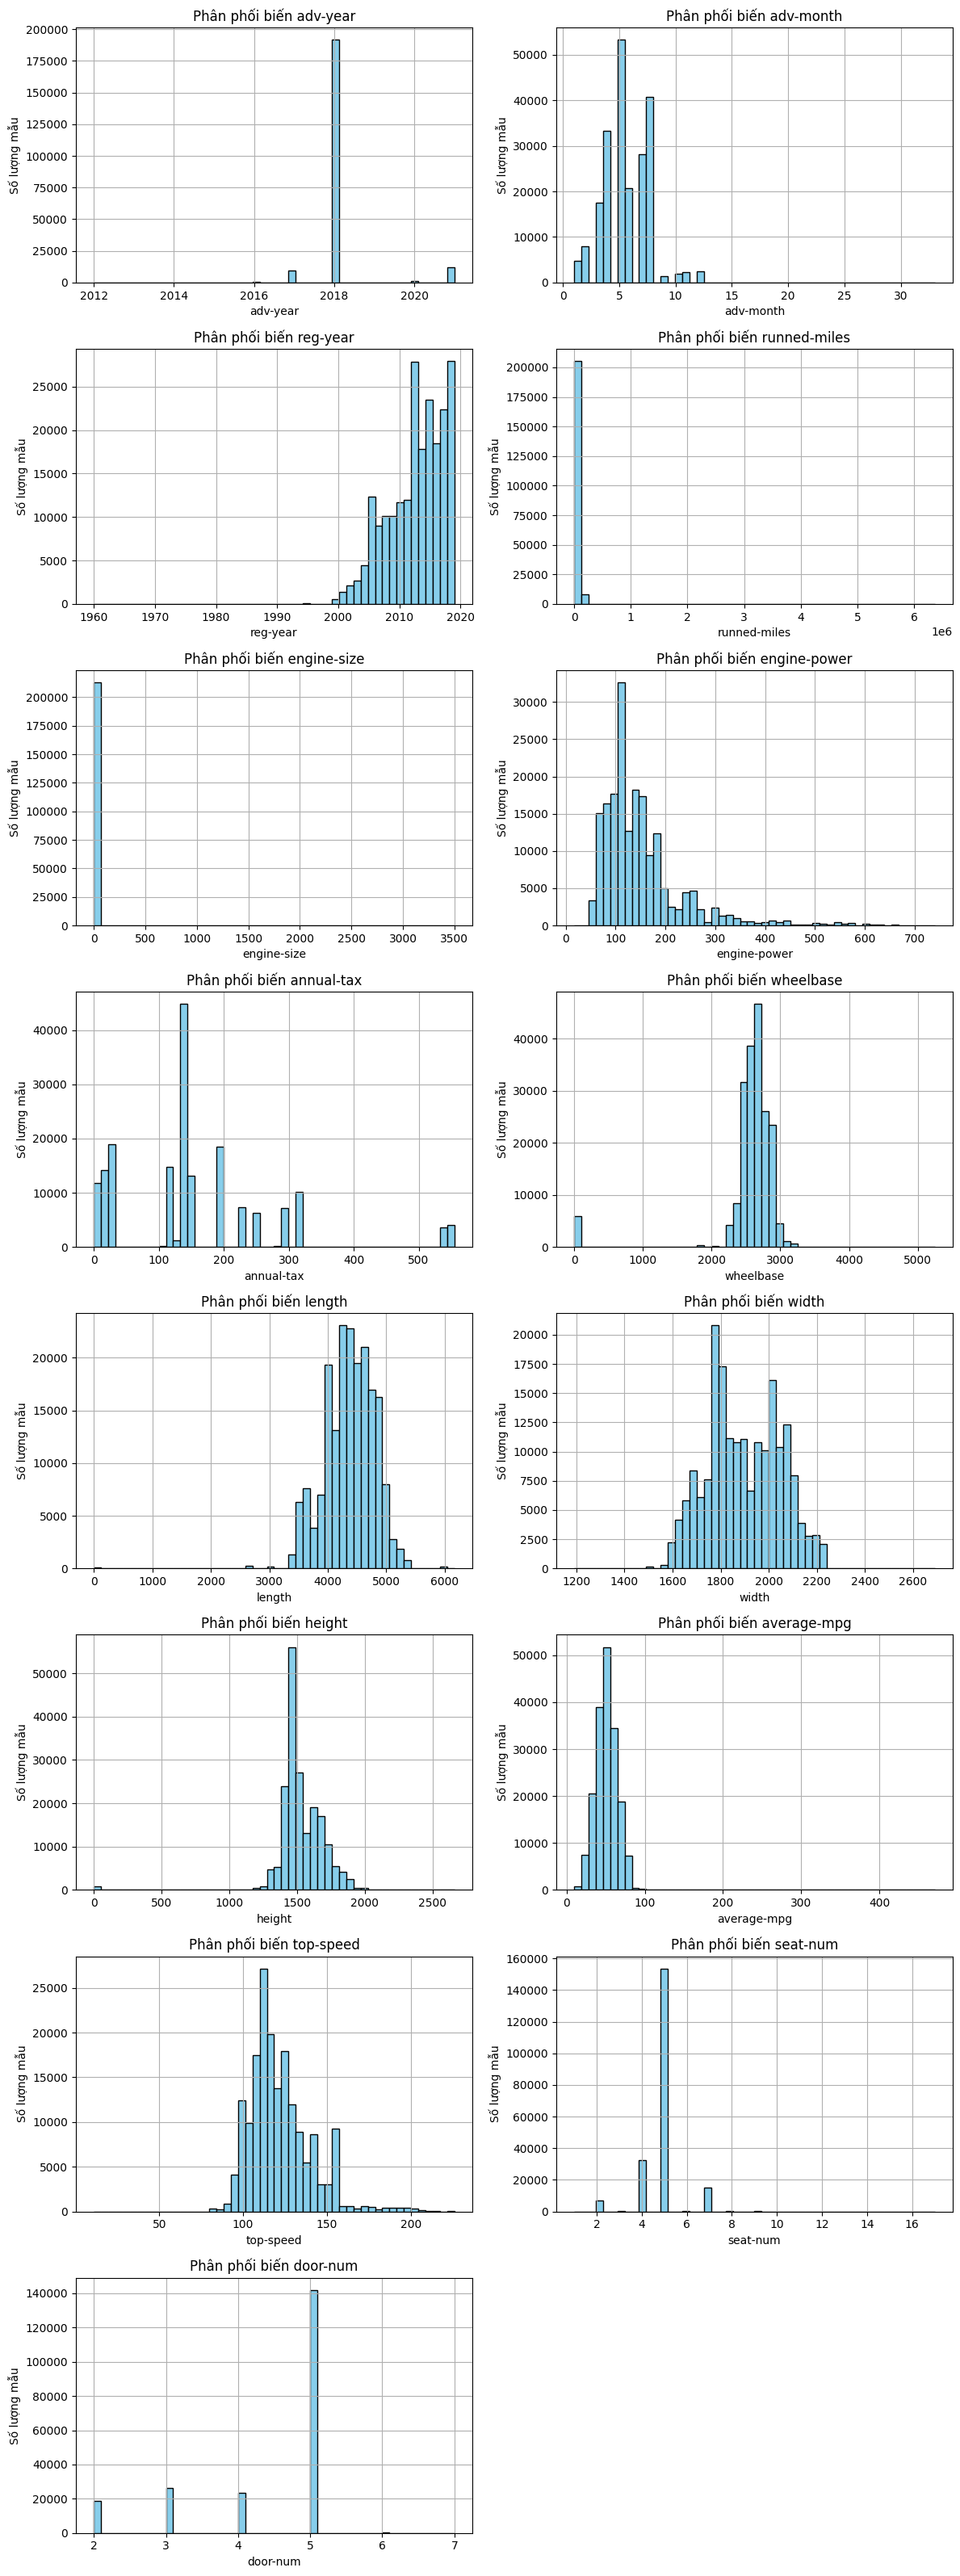

In [15]:
# HISTOGRAM DON BIEN LIEN TỤC
import matplotlib.pyplot as plt

cols = numeric_cols
n_cols = 2
n_rows = (len(cols) + 1) // n_cols

plt.figure(figsize=(12, 4 * n_rows))
for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    x_train[col].dropna().hist(bins=50, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Số lượng mẫu')
    plt.title(f'Phân phối biến {col}')
plt.tight_layout()
plt.show()

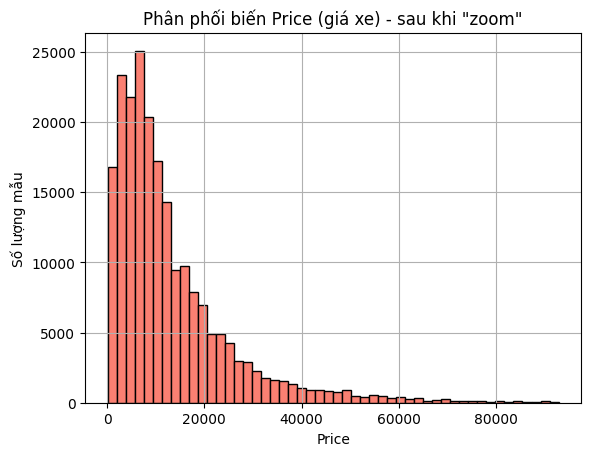

In [16]:

upper = y_train.quantile(0.99)
y_train_clip = y_train[y_train <= upper]

y_train_clip.dropna().hist(bins=50, color='salmon', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Số lượng mẫu')
plt.title('Phân phối biến Price (giá xe) - sau khi "zoom"')
plt.show()

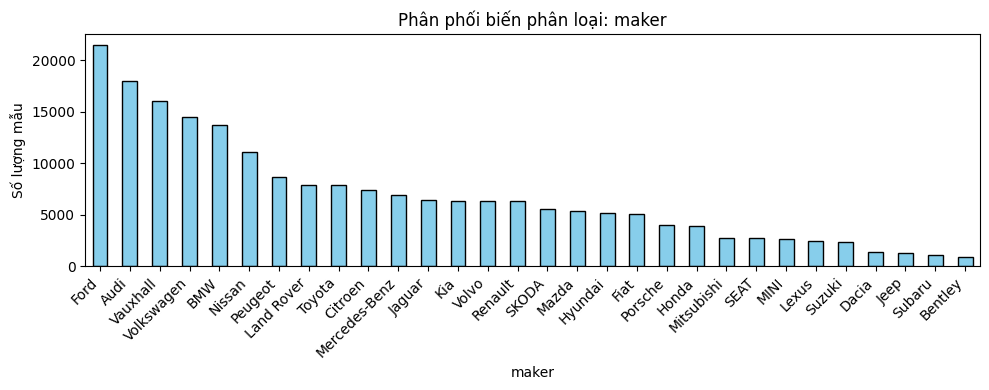

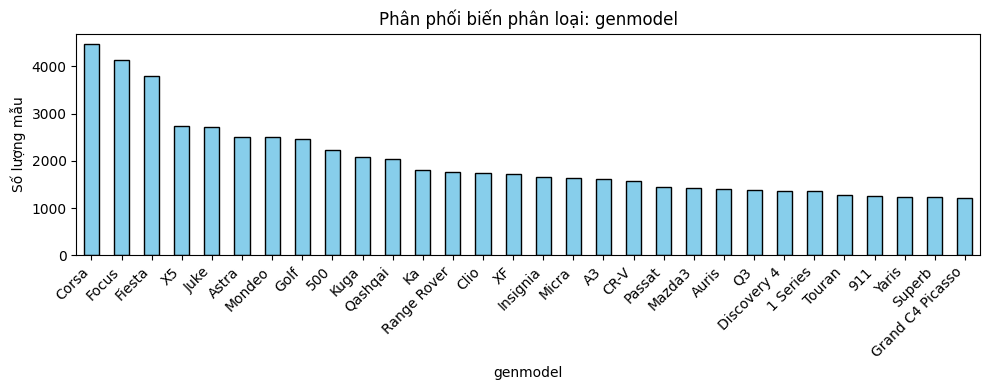

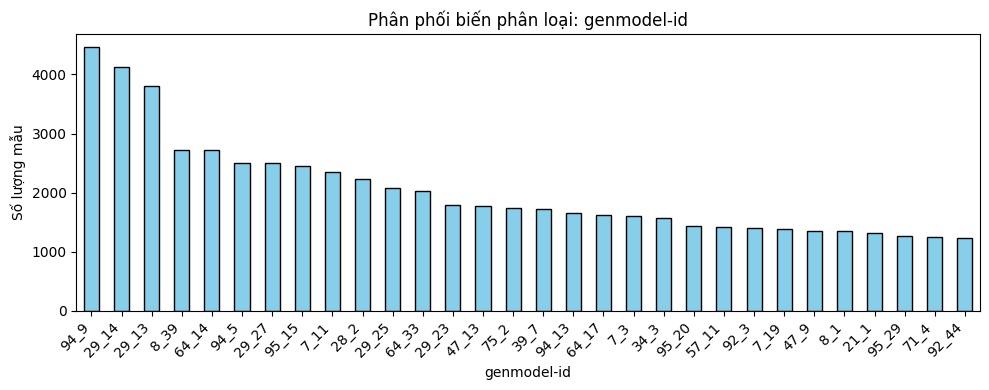

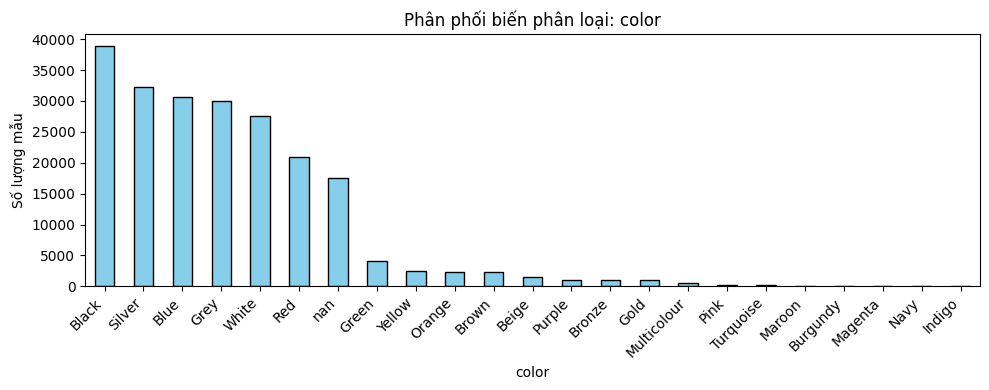

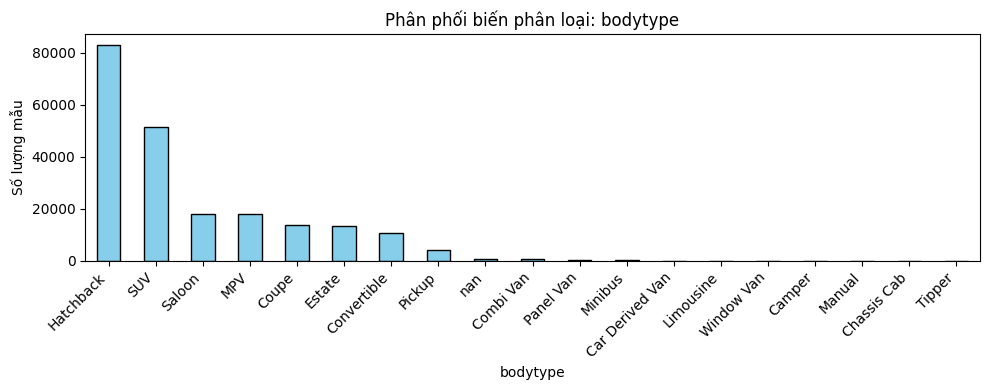

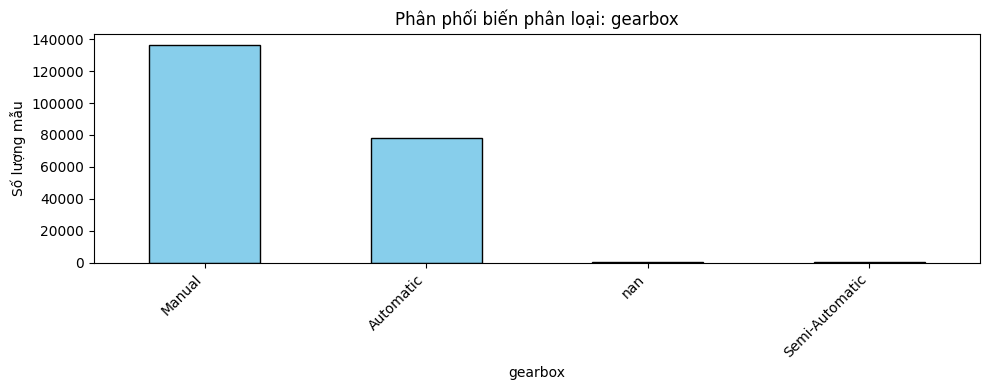

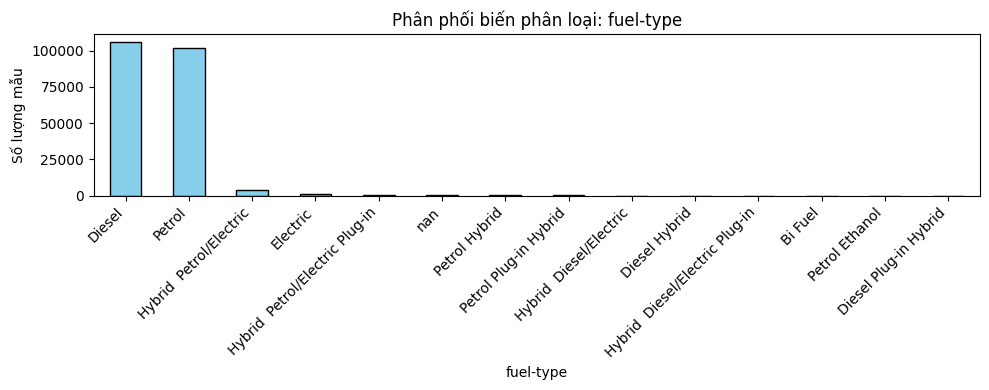

In [17]:
# PHAN PHOI PHAN LOAI
categorical_cols = [col for col in x_train.columns if col not in numeric_cols and col != 'adv-id']

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    x_train[col].value_counts(dropna=False).head(30).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Phân phối biến phân loại: {col}')
    plt.xlabel(col)
    plt.ylabel('Số lượng mẫu')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

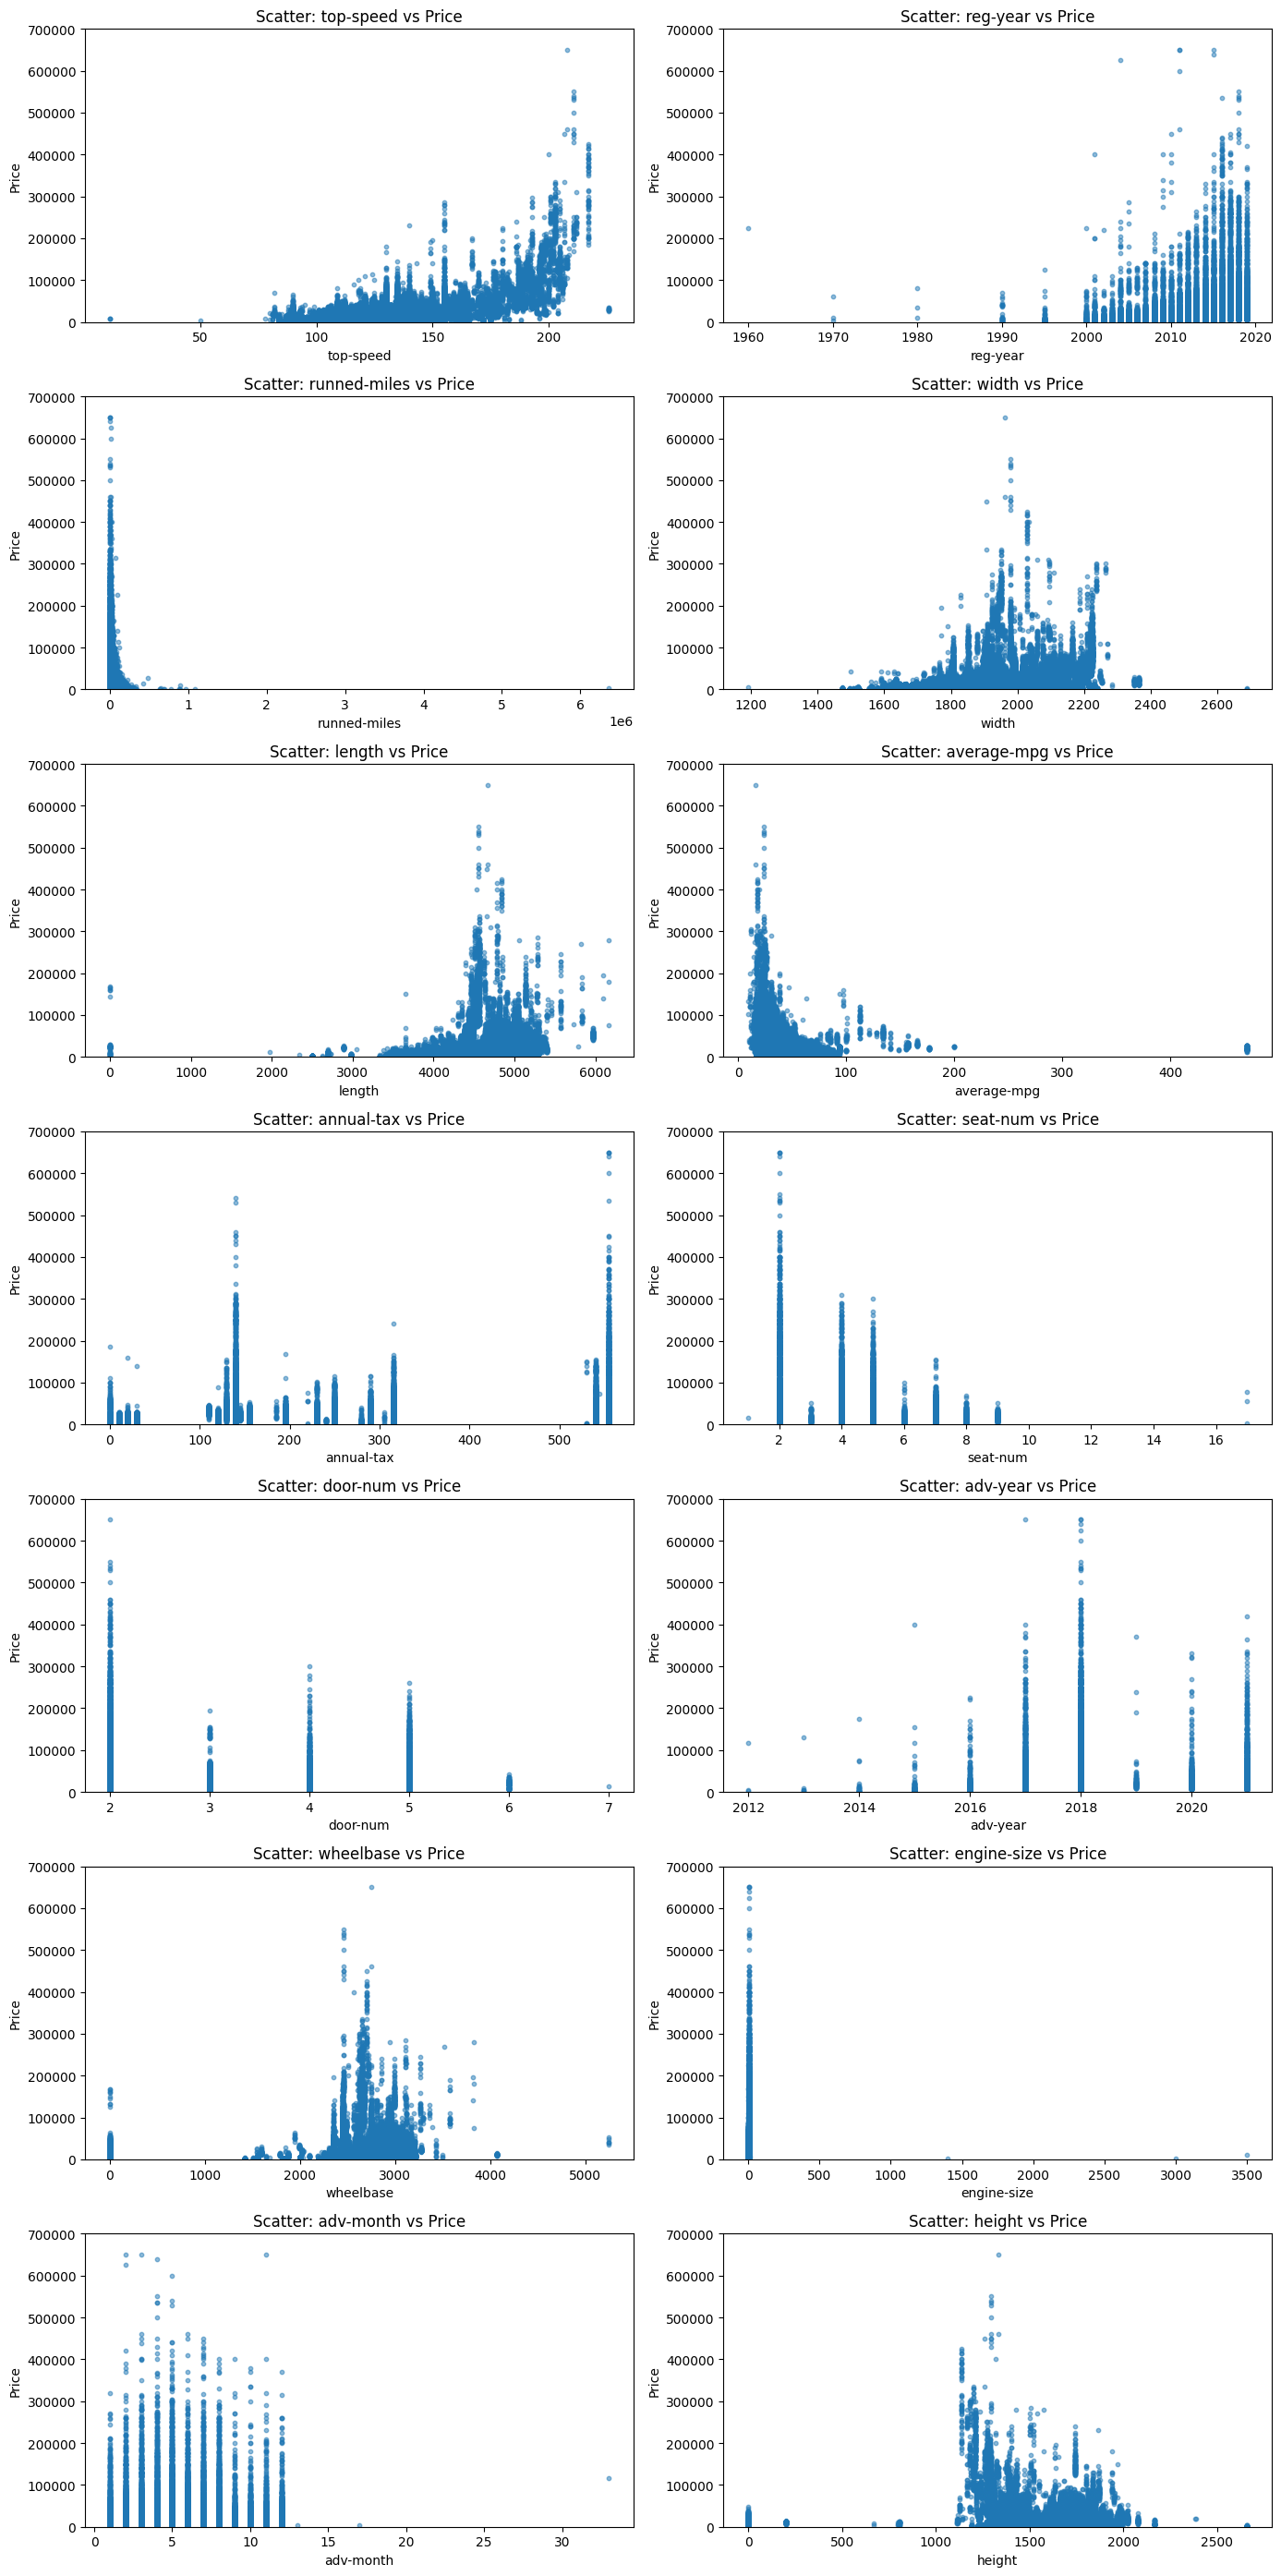

In [18]:
# TUONG QUAN GIUA BIEN LIEN TUC VA GIA

import seaborn as sns

corr_matrix = x_train[numeric_cols].join(y_train).corr()
top_corr_cols = [col for col in corr_matrix['Price'].abs().sort_values(ascending=False).index if col != 'Price'][1:16]

n_cols = 2
n_rows = (len(top_corr_cols) + 1) // n_cols

plt.figure(figsize=(14, 4 * n_rows))
for i, col in enumerate(top_corr_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(x_train[col], y_train, s=10, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.title(f'Scatter: {col} vs Price')
    plt.ylim([0, 700000])  # Zoom loại outlier
plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


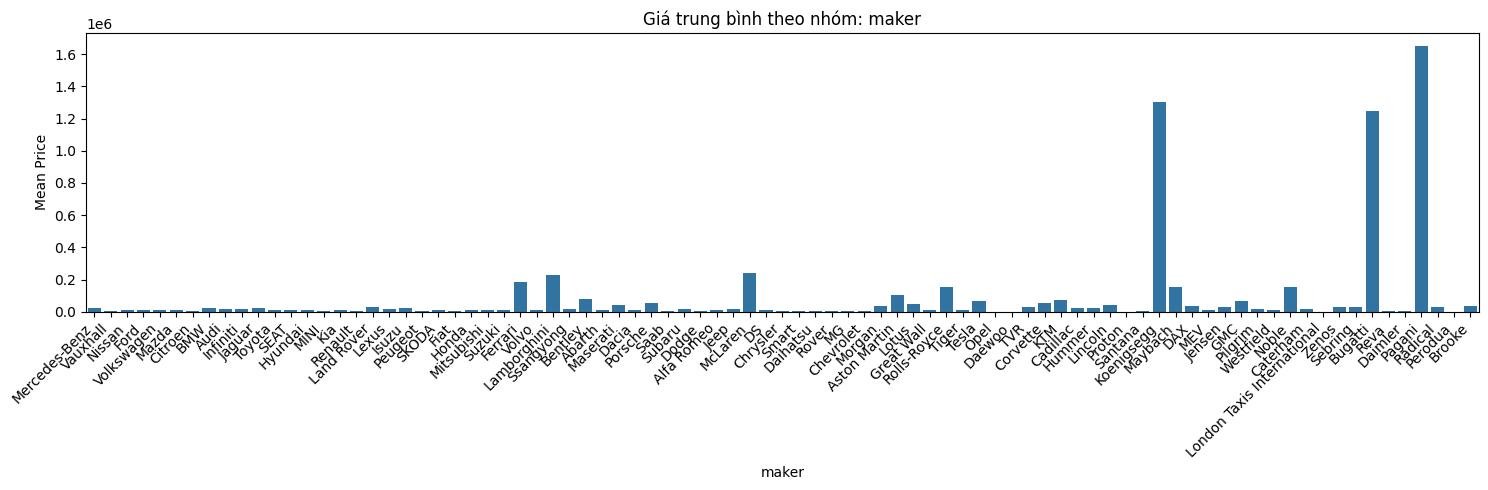

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


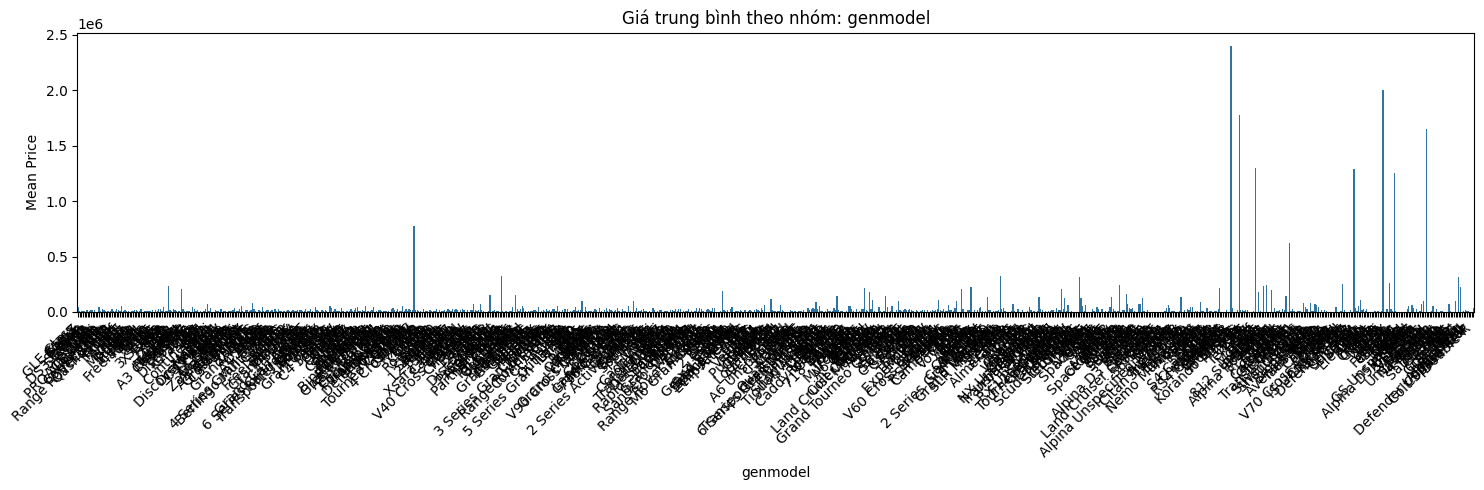

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


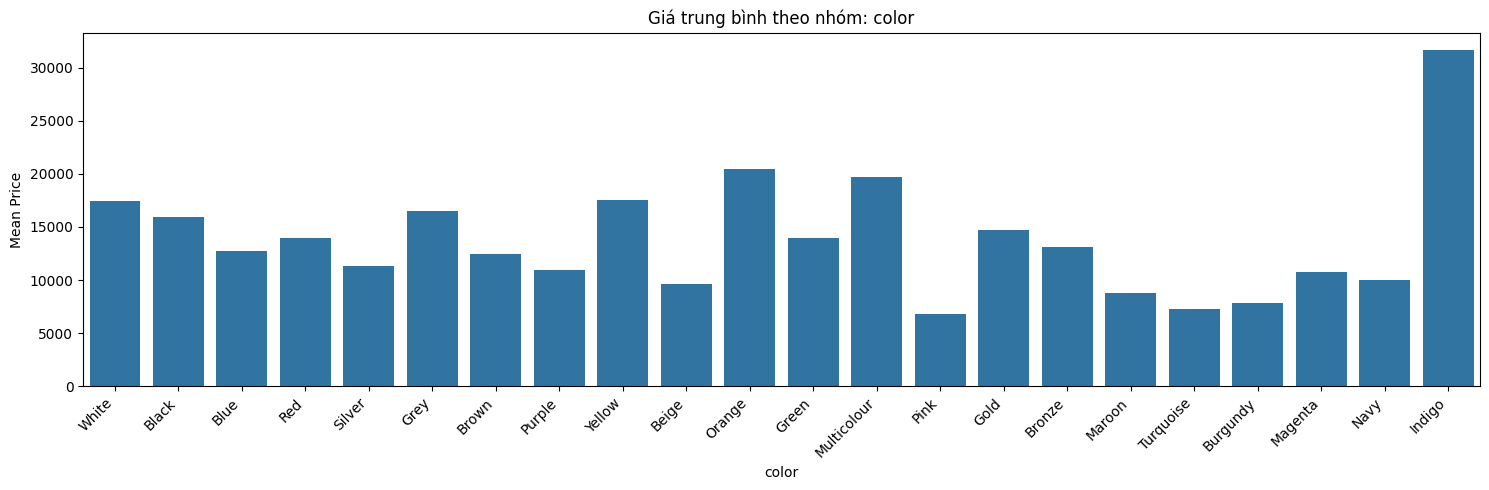

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


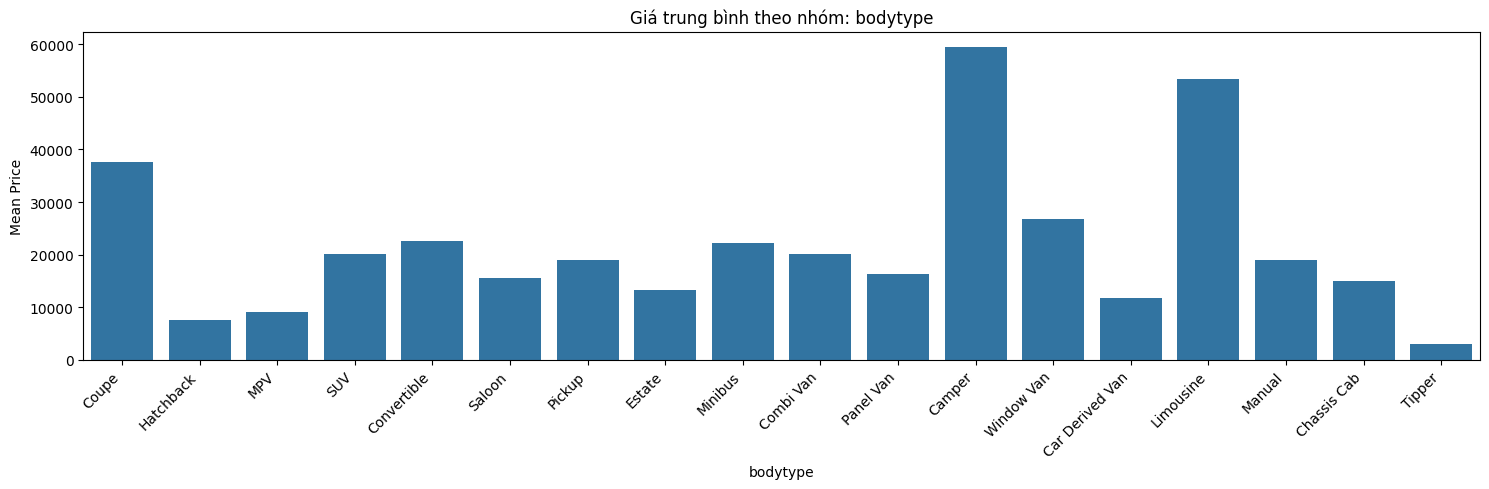

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


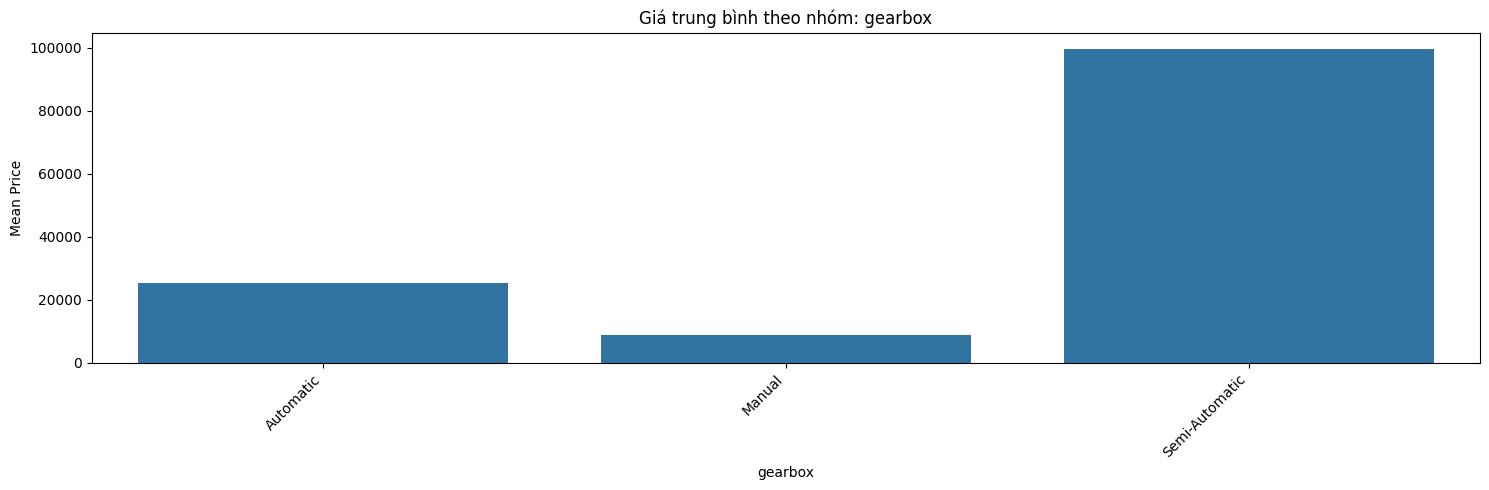

C:\Users\ACER\AppData\Local\Temp\ipykernel_13720\4206368790.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)


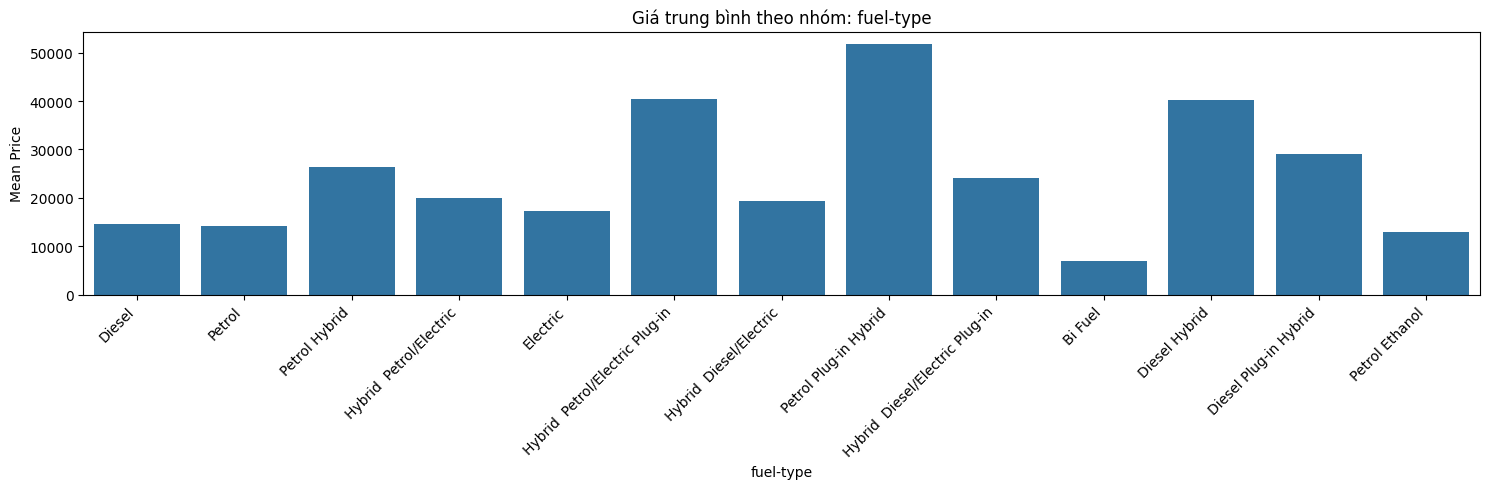

In [19]:
# TUONG QUAN GIUA BIEN PHAN LOAI VS GIA

categorical_cols = [col for col in x_train.columns if col not in numeric_cols and col != 'adv-id' and col != 'genmodel-id']

for col in categorical_cols:
    plt.figure(figsize=(15, 5))
    # Vẽ barplot giá trung bình theo từng nhóm phân loại
    sns.barplot(x=col, y=y_train, data=x_train.join(y_train), estimator=np.mean, ci=None)
    plt.title(f'Giá trung bình theo nhóm: {col}')
    plt.ylabel('Mean Price')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

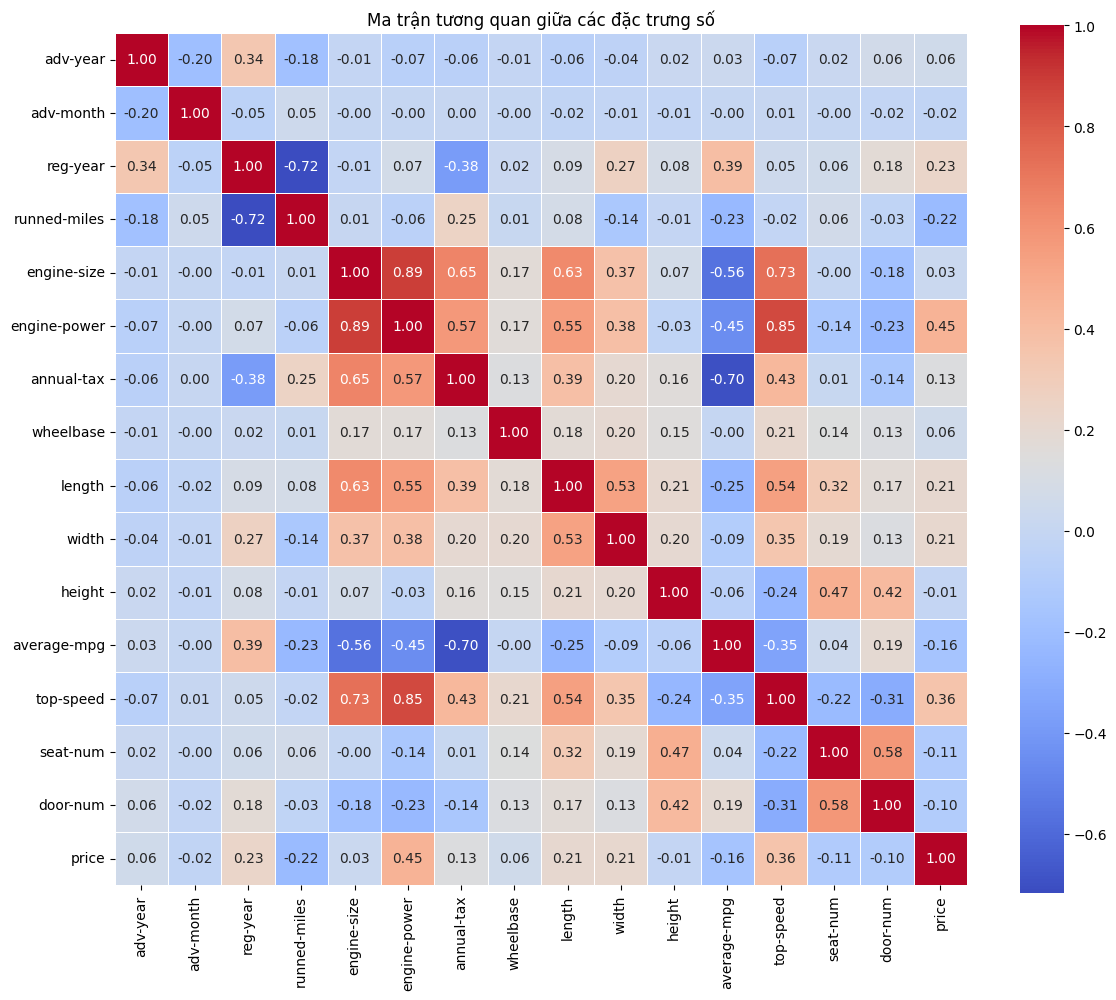

In [20]:
# MA TRAN TUONG QUAN

tmp = x_train[numeric_cols].copy()
tmp['price'] = y_train
corr_matrix = tmp.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Ma trận tương quan giữa các đặc trưng số")
plt.tight_layout()
plt.show()